# Bond Copilot: Unleashing Refinitiv Data Library Search API with AI (LLM) - LangChain Python library
This script assists in searching for specific bond information using a series of filters and queries. It utilizes Large Language Model (LLM) such as ChatGPT that being used in this example to help generate the necessary queries based on user input.

### Disclaimer
The source presented here as well as the example code provided has been written by Refinitiv, an LSEG business for the only purpose of illustrating an article published on the Developer Community. They have not been tested for usage in production environments. Refinitiv cannot be held responsible for any issues that may happen if these objects or the related source code is used in production or any other customer's environment.

## Architecture
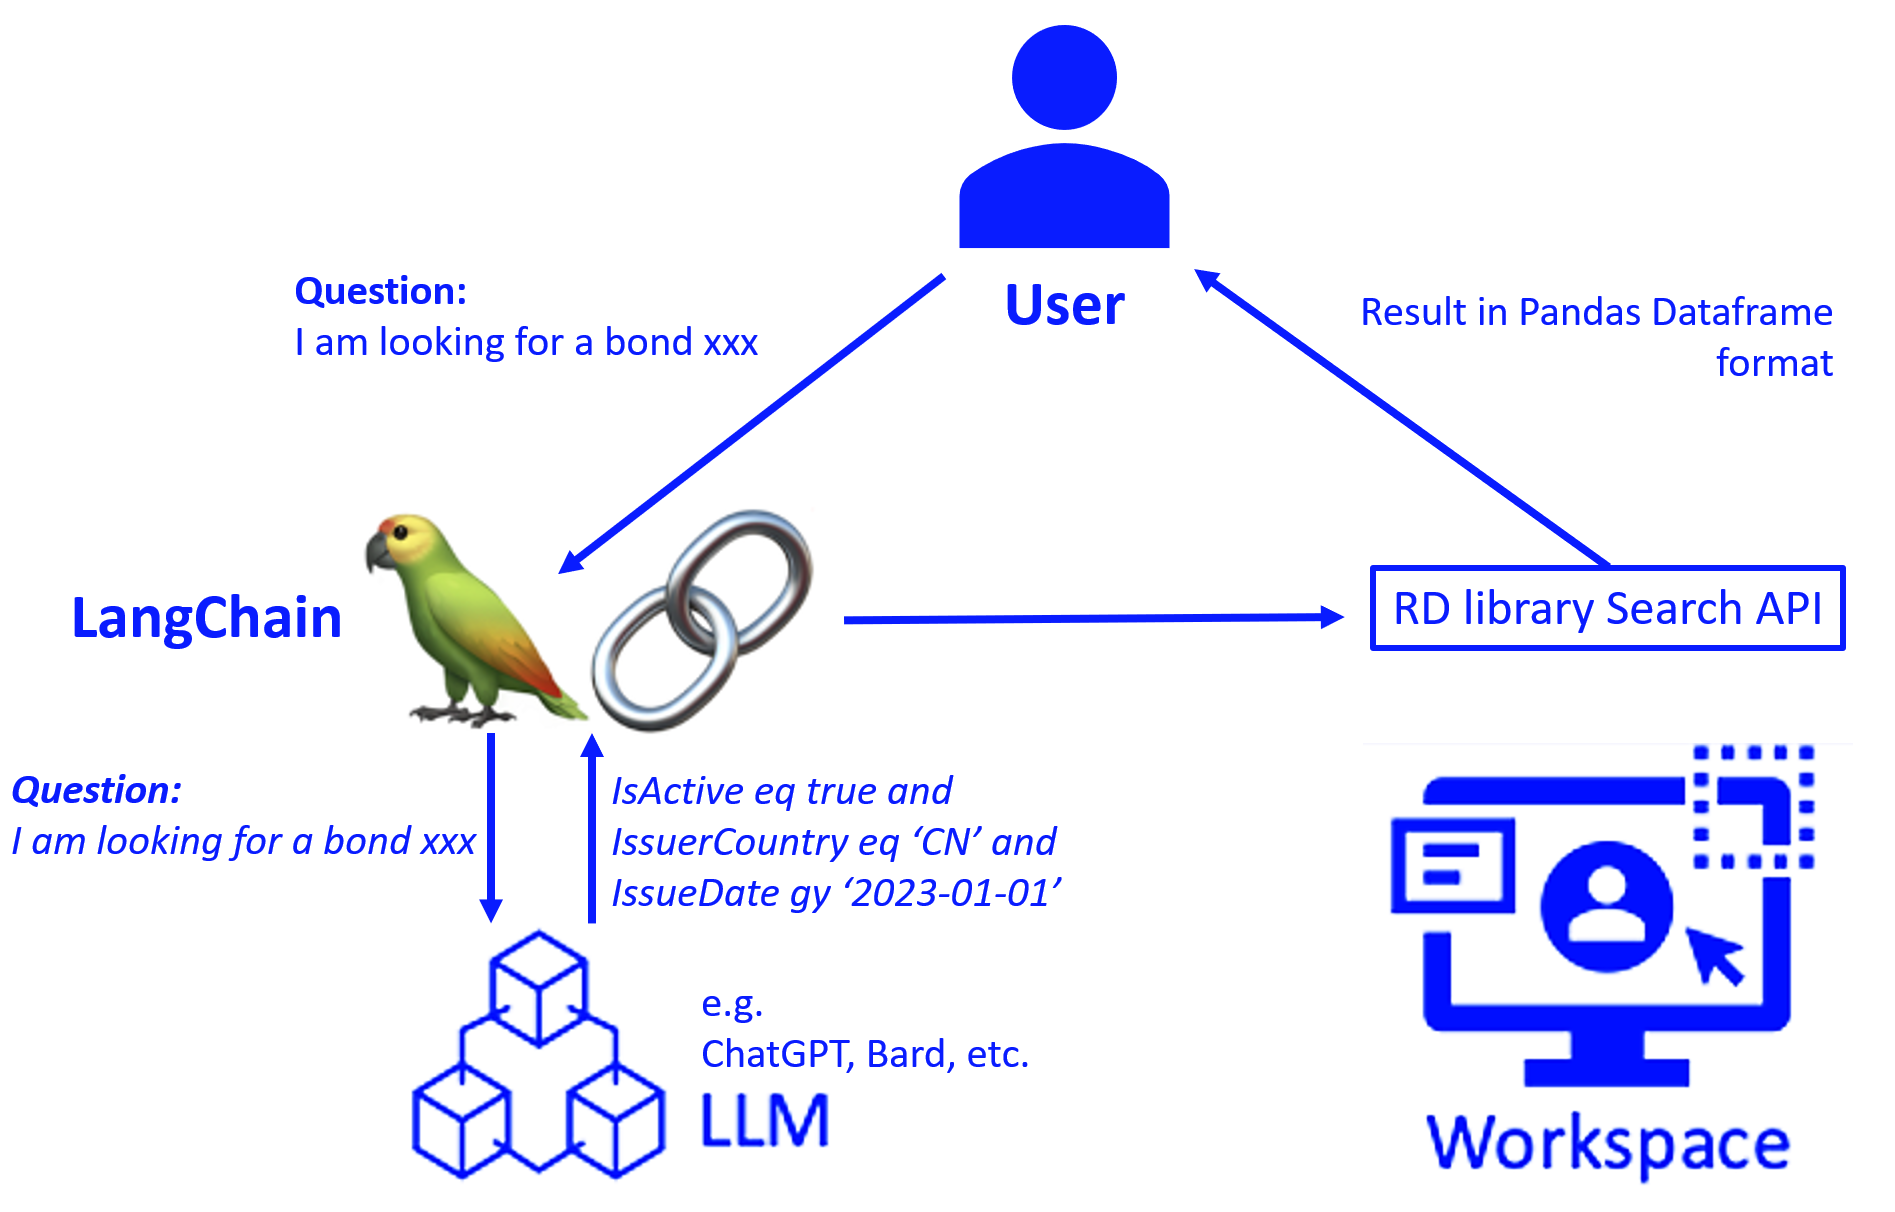

### LangChain Coordination
To smoothly handle multi-turn conversations, Bond Copilot incorporates Langchain to coordinate the interaction between the front-end nature language query and LLM, maintaining context and directing prompts to large language models. Langchain removes the complexity of conversing with AI, making the technology more practical and scalable.

### Large Language Model
Under the hood, Bond Copilot leverages large language models to understand the context and intent and convert nature language query into RD Library Search API.

### RD Library Search API
To enable robust AI insights, Bond Copilot connects to LSEG's RD Library Search API. This provides direct access to LSEG's vast fixed income information including real-time pricing, reference data and more. By leveraging comprehensive, timely data, the quality of Copilot's analytics is significantly enhanced.

## Conversational Search
### Define you bond search function
To begin, it is imperative to craft a bond search function named 'ws_bond_search,' harnessing the capabilities of the RD Library Search API. We could potentially employ the function outlined in the subsequent comments to acquire bond metadata, an essential step in formulating the API search function. The variable 'query' assumes a pivotal role, serving as the conduit for stipulating the criteria for retrieving bond-related information.
For more detail regarding RD library and how to configure it, please check the [Getting started with Refinitiv Data Library for Python guide](https://developers.refinitiv.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-library-for-python/quick-start#getting-started-with-python)

In [1]:
# Imports the RD library
import refinitiv.data as rd  
from refinitiv.data.content import search

# Initialize the session with the RD library, using a configuration file to set up the connection.
rd.open_session(config_name="path/to/your/config/file/refinitiv-data.config.json")

"""
Search function: The code below It can be used to retrieve metadata about government and corporate bonds
to help construct your search queries by defining 'filter' and 'select' parameters in your search query

response = search.metadata.Definition(
    view = search.Views.GOV_CORP_INSTRUMENTS
).get_data()
response.data.df
"""

# The function below is designed to search for bonds based on a query input. 
# It will return a dataframe with information about bonds that match the criteria specified in the query.

def ws_bond_search(query):
    df = rd.discovery.search(
            # Specifies the database view we are searching in.
            view = search.Views.GOV_CORP_INSTRUMENTS,
            # Limits the results to the top 10,000 matches.
            top = 10000,
            # Applies the query filters to narrow down the search results.
            filter = query,
            # Selects specific data columns to be included in the output.
            select = '''
                    RIC,
                    ISIN,
                    IssueDate,
                    FaceIssuedTotal,
                    EOMAmountOutstanding,
                    CouponRate,
                    CouponCurrency,
                    CouponFrequency,
                    CurrentYield,
                    EOMPrice,
                    IssuePrice,
                    MaturityAverageLife,
                    MaturityAverageLifeDate,
                    ISOCountryName,
                    IssuerLegalName,
                    IssuerCountry,
                    MaturityDate,
                    AssetStatus,
                    IsActive,
                    IsGreenBond
                        ''',
            order_by = "IssueDate"
    )
    # Returns the data frame with the search results.
    return df

## Define Few-Shot prompt template
Moving forward, the subsequent stride involves the creation of a function named 'bond_copilot.' This function assumes the task of translating a query presented in natural language into a filter suitable for the RD Library Search API, facilitated by the Few-Shot Prompt Template. This resulting filter subsequently serves as a parameter for the 'ws_bond_search' function.

The concept of 'Few-shot' denotes a remarkable capability conferred by LLMs. It enables tasks to be accomplished using merely a limited number of examples or data "shots" and natural Language is becoming a programming language to preform prompt engineering tasks

*In the code below, replace YOUR OPENAI API KEY with your valid OpenAI API key*

In [2]:
# Import several modules that help us in generating queries using natural language processing.
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate
#from langchain.llms import LlamaCpp
from langchain.chat_models import ChatOpenAI 

In [3]:
# This function takes a user's question as a input and generates a query filter for searching bonds with the RD library.

def bond_copilot(question):
    
    # The template below guides the construction of the query based on the user's input.
    template = """
This is a tool to generate the filter in RD Library search api, for example:

Question: I'm looking for all US Corporate Bonds that have a minimum outstanding amount of 1,000,000 in the Biotechnology Industry and are maturing no earlier than 10 years"

Answer: RCSTRBC2012Name eq 'Biotechnology & Medical Research' and MaturityDate gt 2030-01-01 and IssuerCountry eq 'US' and EOMAmountOutstanding gt 1000000

Comments:
1) IssuerCountry is Country Code: Unite State - US; China - CN; Europe - EU
2) RCSTRBC2012Name is industry classification code: Biotechnology & Medical Research, Software & IT Services, Real Estate Operations(Chinese is 房地产) etc.
3) Green Bond: IsGreenBond eq true

Here is the list of all query fields and datatype:
RIC                        string[python]
ISIN                       string[python]
IssueDate                  datetime64[ns]
FaceIssuedTotal                     Int64
EOMAmountOutstanding                Int64
CouponRate                        Float64
CouponCurrency             string[python]
CouponFrequency                     Int64
CurrentYield                      Float64
EOMPrice                          Float64
IssuePrice                        Float64
MaturityAverageLife               Float64
MaturityAverageLifeDate    datetime64[ns]
IssuerLegalName            string[python]
IssuerCountry              string[python]
MaturityDate               datetime64[ns]
AssetStatus                string[python]
IsActive                          boolean
IsGreenBond                       boolean

Reference grammar: = is eq; > is gt, < is lt

Please output answer directly without any comments

QUESTION: {question}
ANSWER: 
"""

    prompt = PromptTemplate(input_variables=["question"], template=template)
    
    # Initialize the language model that will help in generating the query.
    
    llm = ChatOpenAI(temperature=0, model_name='gpt-3.5-turbo', openai_api_key='YOUR OPENAI API KEY')
    
    # Creates a chain of processes to generate the query using the language model.
    llm_chain = LLMChain(llm=llm, prompt=prompt)

    # This block generates the query filter based on the user's input and then uses it to search for bonds.
    my_filter = llm_chain(question)

    print(my_filter['text'])
    
    # Uses the generated query to search for bonds and returns the results.
    return ws_bond_search(my_filter['text']) 

Let's try using the function with a specific bond identifier as the search query.

The query filter is printed with the output dataframe

### Begin the journey of "bond copilot"
We are now poised to embark on the "Bond Copilot" journey across a vast expanse of more than 12 million global corporate and government bond entries.

**Question One:** “I am looking for a bond whose Isin is XS2404581527”

Query generated by the model is ISIN eq 'XS2404581527', the result of the Search API in Pandas dataframe is shown below

In [4]:
bond_copilot('I am looking for a bond whose isin is XS2404581527')

ISIN eq 'XS2404581527'


,ISIN,IssueDate,CouponRate,CouponCurrency,CouponFrequency,IssuePrice,IssuerLegalName,IssuerCountry,MaturityDate,AssetStatus,IsActive,IsGreenBond
0,XS2404581527,1970-01-01,0,USD,2,100,Zhong Guo Tian Rui Ji Tuan Shui Ni You Xian Go...,CN,2023-11-18,ISS,True,False


**Question Two:** “I am looking for all China Corporate Bonds issued in 2023 that have a minimum outstanding amount of 1,000,000 in the real estate”
Query generated is IssuerCountry eq 'CN' and IssueDate gt 2023-01-01 and EOMAmountOutstanding gt 1000000 and RCSTRBC2012Name eq 'Real Estate Operations', and got the result as below

In [5]:
df = bond_copilot("I'm looking for all China Corporate Bonds issued in 2023 that have a minimum outstanding amount of 1,000,000 in the real estate")
df.head(3)

IssuerCountry eq 'CN' and IssueDate gt 2023-01-01 and EOMAmountOutstanding gt 1000000 and RCSTRBC2012Name eq 'Real Estate Operations'


,RIC,ISIN,IssueDate,FaceIssuedTotal,EOMAmountOutstanding,CouponRate,CouponCurrency,CouponFrequency,CurrentYield,EOMPrice,IssuePrice,MaturityAverageLife,MaturityAverageLifeDate,IssuerLegalName,IssuerCountry,MaturityDate,AssetStatus,IsActive,IsGreenBond
0,CN012380015=,CND10005ZBQ9,2023-01-03,700000000,700000000,4.98,CNY,0,4.975104,100.1601,100,0.046575,2023-09-28,Yan Cheng Dong Fang Tou Zi Kai Fa Ji Tuan You ...,CN,2023-09-28,ISS,True,False
1,<NA>,CND10005ZFB2,2023-01-03,600000000,600000000,4.4,CNY,0,4.399811,100.1626,100,0.002762,2023-07-03,Nan Jing Wei Lai Ke Ji Cheng Jing Ji Fa Zhan Y...,CN,2023-07-03,MAT,False,False
2,<NA>,CND10005ZF48,2023-01-03,400000000,400000000,3.08,CNY,0,3.079963,100.0011,100,0.002747,2023-04-04,Su Zhou Wu Zhong Jing Kai Guo You Zi Chan Tou ...,CN,2023-04-04,MAT,False,False


### Multi-Language Support
Chinese query of “List green bonds issued by US real estate companies”

In [6]:
df = bond_copilot("请列出发型商是美国的绿色公司债券，行业分类是房地产:Real Estate"); df.head(3)

IssuerCountry eq 'US' and RCSTRBC2012Name eq 'Real Estate Operations' and IsGreenBond eq true


,RIC,ISIN,IssueDate,FaceIssuedTotal,EOMAmountOutstanding,CouponRate,CouponCurrency,CouponFrequency,CurrentYield,EOMPrice,IssuePrice,MaturityAverageLife,MaturityAverageLifeDate,IssuerLegalName,IssuerCountry,MaturityDate,AssetStatus,IsActive,IsGreenBond
0,75884RAT0=,US75884RAT05,2014-05-16,250000000,250000000,3.75,USD,2,3.821411,98.182,99.482,0.763889,2024-06-17,"REGENCY CENTERS, L.P.",US,2024-06-15,ISS,True,True
1,<NA>,US929043AH00,2014-06-16,450000000,<NA>,2.5,USD,2,<NA>,<NA>,99.619,<NA>,NaT,VORNADO REALTY L.P.,US,2019-06-30,CLD,False,True
2,<NA>,US25389JAL08,2015-06-23,500000000,<NA>,3.95,USD,2,<NA>,<NA>,99.236,<NA>,NaT,"DIGITAL REALTY TRUST, L.P.",US,2022-07-01,CLD,False,True


Japanese query of “Looking for green bonds issued by Japanese corporations with a minimum balance of 1,000,000 yen”

In [7]:
df = bond_copilot("最低残高1,000,000の全日本法人グリーンボンドを探しています")
df.head(3)

EOMAmountOutstanding gt 1000000 and IssuerCountry eq 'JP' and IsGreenBond eq true


,RIC,ISIN,IssueDate,FaceIssuedTotal,EOMAmountOutstanding,CouponRate,CouponCurrency,CouponFrequency,CurrentYield,EOMPrice,IssuePrice,MaturityAverageLife,MaturityAverageLifeDate,IssuerLegalName,IssuerCountry,MaturityDate,AssetStatus,IsActive,IsGreenBond
0,606822AH7=,US606822AH76,2016-09-13,500000000,500000000,2.527,USD,2,2.528583,99.8972,100.0,0.002778,2023-09-13,Kabushiki Kaisha Mitsubishi Yuefuje Finansharu...,JP,2023-09-13,ISS,True,True
1,JP00034307=,JP376280AG96,2016-09-16,10000000000,10000000000,0.25,JPY,2,0.250986,99.531,100.0,3.010959,2026-09-16,Kabushiki Kaisha Nomura Sogo Kenkyusho,JP,2026-09-16,ISS,True,True
2,JP169421978=,XS1694219780,2017-10-11,500000000,500000000,0.934,EUR,1,0.965864,96.7,100.0,1.079452,2024-10-11,Kabushiki Kaisha Mitsui Sumitomo Finansharu Gu...,JP,2024-10-11,ISS,True,True


In [8]:
bond_copilot("show me China bond issued in Augest,2023 whose yield > 5*1 and coupon > 5*1")

IssuerCountry eq 'CN' and IssueDate gt 2023-08-01 and IssueDate lt 2023-08-31 and CurrentYield gt 5 and CouponRate gt 5


,RIC,ISIN,IssueDate,FaceIssuedTotal,EOMAmountOutstanding,CouponRate,CouponCurrency,CouponFrequency,CurrentYield,EOMPrice,IssuePrice,MaturityAverageLife,MaturityAverageLifeDate,IssuerLegalName,IssuerCountry,MaturityDate,AssetStatus,IsActive,IsGreenBond
0,CN102381938=,CND10006YGF2,2023-08-02,644000000,644000000,7.0,CNY,0,7.007849,99.938,100.0,0.904891,2024-08-07,Kun Ming Shi Jiao Tong Tou Zi You Xian Ze Ren ...,CN,2024-08-07,ISS,True,False
1,CN251804SH=,<NA>,2023-08-02,141000000,141000000,8.2,CNY,1,8.129654,100.8127,100.0,1.89863,2025-08-04,Teng Chong Shi Jian An Cheng Xiang Tou Zi Kai ...,CN,2025-08-02,ISS,True,False
2,CN042380435=,CND10006WCN9,2023-08-03,1000000000,1000000000,5.83,CNY,0,5.773215,101.0659,100.0,0.334247,2024-01-11,Tian Jin Cheng Shi Ji Chu She Shi Jian She Tou...,CN,2024-01-11,ISS,True,False
3,CN251945SH=,<NA>,2023-08-03,1080000000,1080000000,6.5,CNY,0,6.704501,96.9685,100.0,0.90274,2024-08-05,Ji Ning Shi Yan Zhou Qu Hui Min Cheng Jian Tou...,CN,2024-08-04,ISS,True,False
4,CN102381950=,CND10006Y9F2,2023-08-03,70000000,70000000,7.5,CNY,1,7.482834,100.3324,100.0,2.896175,2026-08-04,Xi An Chan Ba Fa Zhan Ji Tuan You Xian Gong Si,CN,2026-08-04,ISS,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,CN2380220=,CND10006Y8W9,2023-08-29,800000000,800000000,5.37,CNY,1,5.381204,100.1081,100.0,4.968219,2028-08-30,Ping Xiang Chuang Xin Fa Zhan Tou Zi Ji Tuan Y...,CN,2030-08-30,ISS,True,False
60,CN012383333=,CND10006Z278,2023-08-30,2000000000,<NA>,5.55,CNY,0,5.540498,<NA>,100.0,0.375342,2024-01-26,Yun Nan Sheng Tou Zi Kong Gu Ji Tuan You Xian ...,CN,2024-01-26,ISS,True,False
61,CN252274SH=,<NA>,2023-08-30,484000000,484000000,6.8,CNY,1,6.815403,100.0206,100.0,1.975342,2025-09-01,Tai He Xian Guo You Zi Chan Tou Zi Kong Gu Ji ...,CN,2025-08-30,ISS,True,False
62,CN252046SH=,<NA>,2023-08-30,600000000,<NA>,6.3,CNY,1,6.330774,<NA>,100.0,2.972603,2026-08-31,Yi Yang Shi Liang Xing Jian She Tou Zi Ji Tuan...,CN,2026-08-31,ISS,True,False


## Intelligent Bond Analytics and Statistics
After filtering a small bond dataset based on the conditions specified by user using 'bond_copilot' function, the utilization of the LangChain Dataframe Agent comes into play for extended analysis and statistical exploration. This step aids users in acquiring deeper insights.

Below is orchestra diagram of LangChain Agent components.

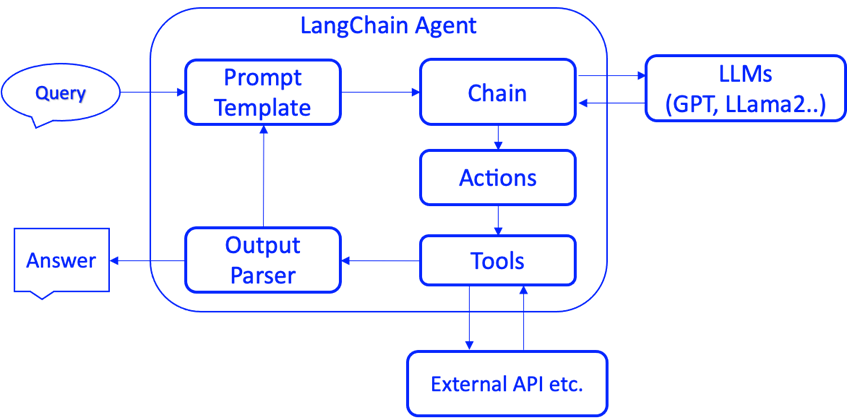

In LangChain Python documentation regarding LangChain Dataframe Agent, it is noted that “this agent calls the Python agent under the hood, which executes LLM generated Python code - this can be bad if the LLM generated Python code is harmful. Use cautiously”. Nonetheless, it is important to underline that this agent offers substantial analytical conveniences, making it worthwhile to showcase its capabilities in the current phase, albeit with a smaller dataset.

**Step 1:** Initiating the LangChain Dataframe Agent with the query outcome derived from the 'bond_copilot' input and creating LangChain Dataframe Agent.

*In the code below, replace YOUR OPENAI API KEY with your valid OpenAI API key*

Or you can replace OpenAI with your preferred LLM (form langchain.llms import <your preferred LLM>)

In [9]:
df = bond_copilot("list all the active green bonds")

IsGreenBond eq true and IsActive eq true


In [10]:
# Importing necessary modules to facilitate data analysis using natural language processing.
from langchain.llms import OpenAI
from langchain.agents import create_pandas_dataframe_agent,create_csv_agent

# Creating an agent that allows us to perform natural language queries on the dataset.
# The agent uses ChatGPT, OpenAI's language model to understand and process the queries.

bond_analytics = create_pandas_dataframe_agent(OpenAI(temperature=0, openai_api_key='YOUR OPENAI API KEY'), df, verbose=False)
#bond_analytics = create_csv_agent(OpenAI(temperature=0), "green_bond.csv", verbose=False)

**Step 2:** Showcasing the Proficiency of the LangChain Agent in Conducting Bond Statistics.

In [11]:
# Finally, we run a specific query to find out the top 5 countries that issued the highest number of bonds in 2020. 
# The query is structured as a natural language question to demonstrate the capabilities of the analytical agent.

bond_analytics.run("how many bonds issued in 2020 group by country sorted by nubmer of bonds, only list top 5")

'The top 5 countries with the most bonds issued in 2020 are Germany (156), China (110), Sweden (98), Japan (82), and the United States (65).'

In [12]:
bond_analytics.run("how many corp green bonds issued in China in 2020, 2021, 2022 group by each year")

'There were 942 corp green bonds issued in China in 2020, 1868 corp green bonds issued in China in 2021, and 1668 corp green bonds issued in China in 2022.'

In [22]:
bond_analytics.run("how many corp green bonds issued in United State in 2020, 2021, 2022 group by each year")

'There were 65 corp green bonds issued in the United States in 2020, 111 in 2021, and 73 in 2022.'

In [24]:
bond_analytics.run("who is the biggest green bond issuer in 2022 (in China)?")

'The biggest green bond issuer in China in 2022 is MODERN LAND (CHINA) CO., LIMITED.'

**Step 3:** Illustrating the LangChain Agent's Proficiency in Conducting Bond Analysis.

In [42]:
bond_analytics.run("What is the average coupon of corp green bonds issued in United State in 2022？output format: 0.00")

'4.60'


In [43]:
bond_analytics.run("What is the average current yield of corp green bonds issued in United State in 2022？ output format:0.00 ")

'5.20'


In [44]:
bond_analytics.run("What is the average coupon of corp green bonds issued in IssuerCountry==CH in 2022？output format:0.00")

'3.29'


In [45]:
bond_analytics.run("What is the average current yield of corp green bonds issued in IssuerCountry==CH in 2022？output format:0.00")

'3.27'


From the obtained results above, we can discern that the average coupon rate of U.S. green bonds issued in 2022 stands at approximately 4.6%, while the prevailing average yield for U.S. green bonds of the same vintage is around 5.2%. This alignment appears reasonable, particularly in light of the Federal Reserve's incremental interest rate adjustments, leading to the present bond yield outpacing the bond's coupon rate. The analogous rationale holds true for Chinese bonds, wherein the prevailing downward trajectory of interest rates in China over recent mirrors an inverse trend.

## Summary and Outlook
Within the context of this article, we present a groundbreaking solution - the Bond Copilot - and illustrate how it harnesses the immense potential of large language models in conjunction with the LangChain framework. The objective is to empower users with the ability to seamlessly navigate a vast array of over 12 million trust bond instruments data using natural language. Furthermore, we showcase the utilization of the LangChain Agent for meticulous bond data analysis. Despite the strides made, the realm of complex bond markets remains rife with challenges.

Relying upon the outputs of large language models within the financial sector is not without its intricacies. Delays in data updates, the limited financial domain acumen of these models, and the difficulty in verifying responses - as these models invariably generate an answer, even if erroneous - all contribute to the complexity.

Consequently, the provision of high-quality financial data by LSEG (London Stock Exchange Group) is pivotal in rendering LLM (large language model) services to financial professionals. The RD Library Search API emerges as a robust avenue for accessing an expansive repository of fixed income data, encompassing real-time prices, reference data, and furnishing AI-driven analyses with precise, up-to-the-minute data.

The solution detailed within this article underscores the LLM's specialization in natural language processing tasks, thereby harnessing its inherent proficiency. The insights, derived from the LSEG's trusted data repository via the RD Library Search API, fortify the responses generated.
Utilizing a conversational interface rather than a traditional search user interface allows customers to directly manipulate data through natural language. This avoids complex UI operations and makes it easier and more efficient for customers to use data.

It is imperative to acknowledge that larger LLM isn't invariably synonymous with better, as considerations regarding the associated costs necessitate prudence. For instance, small models with 6 or 7 billion parameters, through fine-tuning, can still be utilized to address specific business challenges at a lower cost and tried both GPT 3.5 and Llama 7B in this case.

The ascent of large language models has indubitably revolutionized our interaction with financial data. The fusion of natural language comprehension with these models has simplified the information acquisition process for analysts. By enabling them to pose inquiries and receive intricate insights into financial markets, the advent of advanced AI tools grounded in LLM technology is dynamically reshaping the roles of financial analysts, investors, and risk managers. This paradigm shift enhances their capacity to navigate complex information with heightened efficiency and efficacy.

## Reference
- [LSEG Workspace](https://www.refinitiv.com/en/products/refinitiv-workspace/)
- [Refinitiv Data library](https://developers.refinitiv.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-library-for-python) and [it's quick start guide for Python](https://developers.refinitiv.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-library-for-python/quick-start#getting-started-with-python)
- [OpenAI API](https://platform.openai.com/)
- [LangChain](https://python.langchain.com/docs/get_started/introduction)
- For any questions related to the RD library usage, feel free to visit or ask you question in the Developers Community [Q&A Forum](https://community.developers.refinitiv.com/index.html).

# Thank you